# Introduction

This notebook shows an example of relaxing the LiFePO4 crystal.

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

> Note: Because Google Colab's python version is sometimes rather old (v3.7 at the time of writing this notebook (Jul 2022), you will need to install m3gnet without dependencies and install the dependencies manually.

In [1]:
# !pip install --no-deps m3gnet
# !pip install pymatgen ase
# !pip install lxml

In [2]:
import warnings

import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.util.coord import pbc_diff

from m3gnet.models import Relaxer

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

/Users/shyue/repos/pymatgen/pymatgen/analysis/phase_diagram.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
mpr = MPRester()
lfp = mpr.get_structure_by_material_id("mp-19017")  # This is LiFePO4.

lfp_strained = lfp.copy()  # We create a copy.
# Create a random strain between -5% and 5% for each direction
strains = np.random.uniform(low=-0.05, high=0.05, size=3)
lfp_strained.apply_strain(strains)
# In addition to the lattice strains, we also perturb the atoms by a distance of 0.1 angstrom.
lfp_strained.perturb(0.1)

/Users/shyue/repos/pymatgen/pymatgen/ext/matproj.py:1758: UserWarning: You are using a new API key. This unofficial MPRester support for the new API is intended purely to facilitate simple convenience queries in the interim. There are no plans to build this into a full-featured API client. It is highly recommended that you install the mp-api package for full API functionality.
  warnings.warn(


In [4]:
relaxer = Relaxer()
relax_results: dict
%time relax_results = relaxer.relax(lfp_strained)
relaxed = relax_results["final_structure"]

2022-07-28 13:54:26.805333: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


CPU times: user 22.9 s, sys: 44.7 s, total: 1min 7s
Wall time: 12.6 s


Note that the relaxation only took < 20s.

In [5]:
print(f"Original lattice parameters are {[round(x, 3) for x in lfp.lattice.abc]}")
print(f"Strained lattice parameters are {[round(x, 3) for x in lfp_strained.lattice.abc]}")
print(f"Relaxed lattice parameters are {[round(x, 3) for x in relaxed.lattice.abc]}")

Original lattice parameters are [4.746, 10.444, 6.09]
Strained lattice parameters are [4.813, 10.658, 6.157]
Relaxed lattice parameters are [4.751, 10.451, 6.091]


In [6]:
print(f"Diff in fractional coords:\n{pbc_diff(lfp.frac_coords, relaxed.frac_coords)}")

Diff in fractional coords:
[[-6.44295515e-05  4.42190331e-03 -8.88747675e-03]
 [ 1.01354042e-02 -3.59713796e-03  4.00084024e-03]
 [ 1.02735788e-02  2.84398857e-03 -6.87950406e-03]
 [-6.30657207e-03  3.25853396e-03 -8.15319630e-03]
 [ 2.55439830e-03  3.13837100e-04  2.73700429e-03]
 [ 4.27699688e-03 -8.28934507e-04  5.22431816e-03]
 [-5.10305099e-03  2.62811369e-04  1.27624838e-03]
 [ 3.20187893e-03  1.12031331e-03  8.20301701e-04]
 [ 1.36107513e-03  8.19890738e-04  2.87038964e-04]
 [ 3.59550881e-03 -3.44683169e-04 -4.25391857e-03]
 [ 3.56245404e-03  1.54407833e-04  3.12803116e-03]
 [-7.94215693e-04 -2.07348846e-03 -8.65240814e-04]
 [ 3.17932869e-03 -1.52997662e-03  1.28374732e-03]
 [ 3.71227991e-03 -1.60643486e-03 -2.80079129e-03]
 [ 2.40632945e-03  5.02697953e-04 -2.25687770e-03]
 [-1.46934998e-03 -9.22684516e-05 -6.02061152e-03]
 [ 1.12287755e-03 -6.49010452e-04 -1.19041894e-03]
 [-1.19763132e-03 -1.78566718e-03  3.91931748e-03]
 [ 5.54552805e-04  1.21783152e-03 -9.66906134e-03]
 [ 4

Quite clealy, the relaxation using the M3GNet universal IAP has brought the lattice parameters much closer to the original DFT one and the coordinates are also within $10^{-3}$ of the original fractional coordinates.

WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 3.625e-09*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 3.625e-09*i)


Text(0.5, 0, 'DOS')

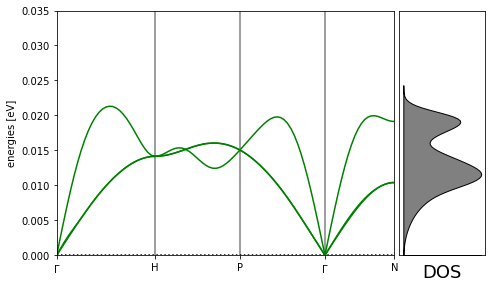

In [17]:
from ase.phonons import Phonons
from pymatgen.io.ase import AseAtomsAdaptor

from m3gnet.models import M3GNet, M3GNetCalculator, Potential

relaxed = mpr.get_structure_by_material_id("mp-129")

# Setup crystal and EMT calculator
atoms = AseAtomsAdaptor().get_atoms(relaxed)

potential = Potential(M3GNet.load())

calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# Phonon calculator
N = 7
ph = Phonons(atoms, calculator, supercell=(N, N, N), delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath("GHPGN", npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

# Plot the band structure and DOS:
import matplotlib.pyplot as plt  # noqa

fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([0.12, 0.07, 0.67, 0.85])

emax = 0.035
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([0.8, 0.07, 0.17, 0.85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color="grey", edgecolor="k", lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

343